In [2]:
#Librerias que necesitamos

import warnings
warnings.filterwarnings("ignore")

import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.colors

import os

from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask

from funciones import nequalize, plot_rgb, delNone

from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

from shapely.geometry import mapping

# os.chdir("C:\\Users\\arell\\Documents\\Sentinel") #Cambiar a directorio en donde se esta trabajando

-------------
# ROIS
----------
## Norte


In [139]:
#directorio en donde esta la imagen
zona = 'norte'
path = '2022/Stack/stack2022'+zona+'.tif'


# OJO, esta armado para este set de bandas y en este orden:
# Bandas 1,2,3,4,5,6,7,8,11 y 12 

s2 = rasterio.open(path) 
s2_bandas = s2.read()
s2_bandas.shape #(cantidad de bandas, alto de la imagen, largo de la imagen)

(10, 10980, 10980)

In [140]:
# Quedo un asco, pero no tenia ganas de arregarlo.
# La idea es que agarra el archivo shp que usamos inicialmente y lo edito con el que hicimos con el ndwi
# Si hay que reeditarlo, al final debe devolver un dataframe con 2 columnas, 
# la primera los nombres de los embalses (discriminado por Norte y Sur) 
# y una segunda columna con la geometría de cada uno

radios = gpd.read_file('geometrias-corregidas/Embalses unificado.shp')#.set_index('id') #Levanta archivo shp
radios.drop(columns=['path', 'objeto','entidad','layer'], inplace = True)
radios['id'] = np.linspace(0,10,11).astype(int)
radios.set_index('id')

Norte = ['Cruz del Eje','San Roque','El Cajon']
Sur = ['Cerro Pelado','Los Molinos','Rio Tercero','La ViÃ±a','Usina 3','Piedra Mora','Arroyo Corto']

radiosN = radios.query('fna in @Norte')
radiosS = radios.query('fna in @Sur')
radiosS

Norte_corregidos = ['Cruz del eje', 'El Cajon', 'San Roque']
radiosNorte_in = gpd.read_file('poligonosnorte/PoligonosEmbalses18-10.shp')
radiosNorte_in.loc[0].geometry

Sur_corregidos = ['Allende','Cerro Pelado','Rio Tercero','Los Molinos','Arroyo Corto','Usina 3','Sin Nombre2','Piedra Mora']
radiosSur_in = gpd.read_file('poligonossur/PoligonosEmbalsesSur18-10.shp')
radiosSur_in.loc[2].geometry

radiosSur = radiosSur_in.assign(fna=Sur_corregidos)
radiosNorte = radiosNorte_in.assign(fna=Norte_corregidos)

radiosSur.set_index('fna')
radiosSur.drop(columns=['id'], inplace = True)
radiosSur = radiosSur[['fna','geometry']]

radiosNorte.set_index('fna')
radiosNorte.drop(columns=['id'], inplace = True)
radiosNorte = radiosNorte[['fna','geometry']]
radiosSur

fna                                           geometry
0       Allende  POLYGON ((309760.000 6477420.000, 309780.000 6...
1  Cerro Pelado  POLYGON ((344100.000 6437120.000, 344120.000 6...
2   Rio Tercero  POLYGON ((365320.000 6440880.000, 365380.000 6...
3   Los Molinos  POLYGON ((354400.000 6483300.000, 354420.000 6...
4  Arroyo Corto  POLYGON ((351300.000 6434980.000, 351320.000 6...
5       Usina 3  POLYGON ((371960.000 6438900.000, 371980.000 6...
6   Sin Nombre2  POLYGON ((367740.000 6441120.000, 367760.000 6...
7   Piedra Mora  POLYGON ((380320.000 6441800.000, 380360.000 6...

In [141]:
radiosNorte

fna                                           geometry
0  Cruz del eje  POLYGON ((332180.770 6595124.339, 332215.686 6...
1      El Cajon  POLYGON ((351041.243 6585831.893, 351043.737 6...
2     San Roque  POLYGON ((361134.245 6532611.069, 361106.812 6...

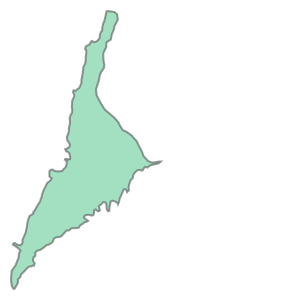

In [142]:
IDEmbalse = 2
nombre = radiosNorte.loc[IDEmbalse].fna
poligono = radiosNorte.loc[IDEmbalse].geometry #geometría del octavo elemento de shp
poligono

In [143]:
s2_plot_extent = plotting_extent(s2) #Bordes de la region a graficar
s2_plot_extent

# Ploteo de la imagen con los poligonos encima
bandasPosicion = [3,2,1] # RGB en este juego de bandas

# img = nequalize(s2_bandas[bandasPosicion], p=5, nodata = None)
# fig, ax = plt.subplots(figsize = (15,8))
# show(img, ax=ax, extent = s2_plot_extent, cmap = 'gray')
# if zona == 'norte':
#     radiosN.boundary.plot(ax=ax, edgecolor = 'red')
# elif zona == 'sur':
#     radiosS.boundary.plot(ax=ax, edgecolor = 'red')
# else:
#     print('Zona debe ser norte o sur')


<AxesSubplot:>

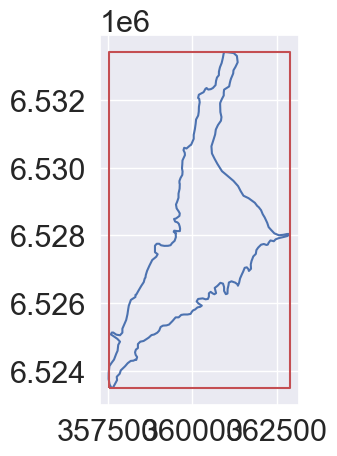

In [144]:
# RECORTO LA ZONA DE INTERES
extent = poligono.envelope

data = [poligono, extent]
gpd.GeoSeries(data).boundary.plot(color=['b', 'r'])

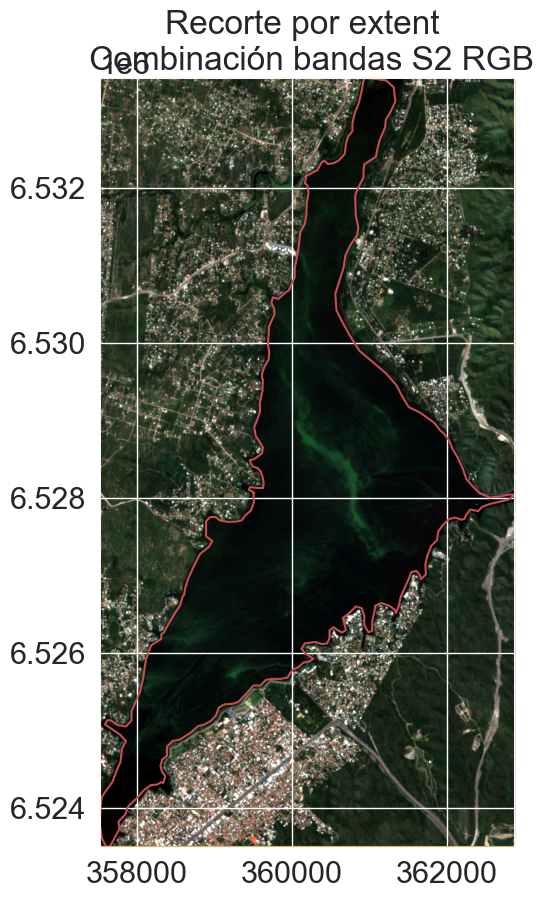

In [145]:
bandasPosicion = [3,2,1] # RGB
# bandasPosicion = [0,1,2] # RGB

s2_clip, clip_transform = mask(dataset = s2, shapes = [extent], crop = True)
fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_clip[bandasPosicion],p=0.5,nodata = None), ax=ax, transform=clip_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por extent \n Combinación bandas S2 RGB")
plt.show()

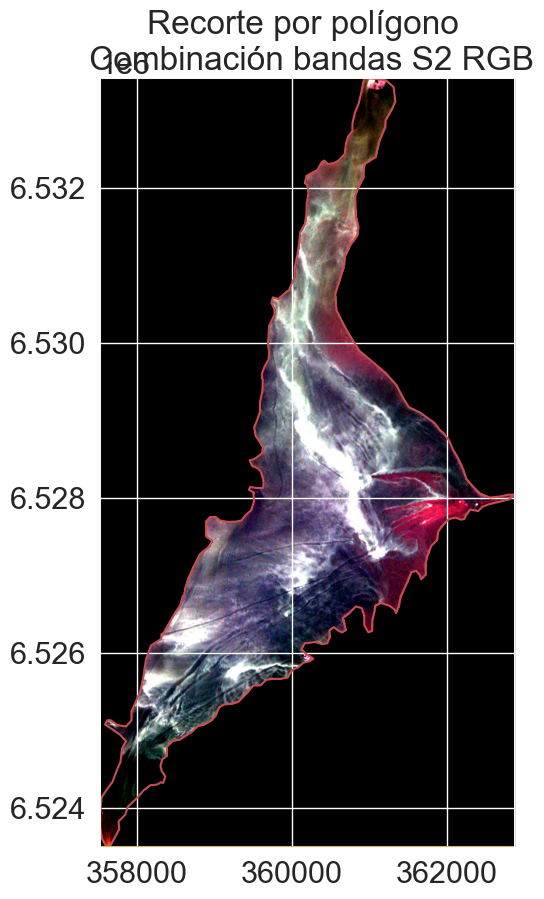

In [146]:
# Me quedo solo con lo dentro de la mascara vectorial
s2_mask, mask_transform  = mask(dataset = s2, shapes = [poligono], crop = True)

fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_mask[bandasPosicion], p=5), ax=ax, transform=mask_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por polígono \n Combinación bandas S2 RGB")
plt.show()

-------------
# Molinos
-------------

In [166]:
path = '2022/molinos/StackRecortado_Molinos_B1a8_11_12.tif'
s2 = rasterio.open(path) 
s2_bandas = s2.read()
s2_bandas.shape #(cantidad de bandas, alto de la imagen, largo de la imagen)

(10, 1182, 692)

In [167]:
radiosM = gpd.read_file('2022/molinos/TrainingMolinosPoligonos.shp')
names = list(set(radiosM['MC_name']))[1:]

In [168]:
radiosMol = radiosM.query('MC_name in @names')
radiosMol

fid  MC_ID     MC_name  C_ID      C_name                    SCP_UID  \
0   None      1  Mucha alga     1  Mucha alga  20221109_222907128230_284   
1   None      1  Mucha alga     1  Mucha alga  20221109_223020241738_942   
2   None      1  Mucha alga     1  Mucha alga  20221109_223256400182_686   
3   None      1  Mucha alga     1  Mucha alga  20221109_223438260938_940   
4   None      1  Mucha alga     1  Mucha alga  20221109_223553404503_616   
5   None      2   Poca alga     2   Poca alga  20221109_223709820598_693   
6   None      2   Poca alga     2   Poca alga  20221109_223839899364_158   
7   None      2   Poca alga     2   Poca alga  20221109_223934861787_415   
8   None      2   Poca alga     2   Poca alga  20221109_223955470504_637   
9   None      2   Poca alga     2   Poca alga  20221109_224111173786_648   
10  None      3    Sin alga     3    Sin alga  20221109_224257890506_555   
11  None      3    Sin alga     3    Sin alga  20221109_225152666113_917   
12  None      3    Sin alga     3    Sin alga  20221109_225253010074_911   
13  None      3    Sin alga     3    Sin alga  20221109_225413463637_563   
14  None      3    Sin alga     3    Sin alga  20221109_225513773990_919   

                                             geometry  
0   POLYGON ((353309.984 6474162.948, 353357.895 6...  
1   POLYGON ((353629.392 6473907.421, 353648.024 6...  
2   POLYGON ((353411.130 6474253.447, 353389.836 6...  
3   POLYGON ((354535.714 6476062.097, 354527.729 6...  
4   POLYGON ((354584.956 6475939.657, 354602.257 6...  
5   POLYGON ((353963.440 6474701.949, 353952.793 6...  
6   POLYGON ((354296.158 6475028.012, 354304.143 6...  
7   POLYGON ((354296.158 6475028.012, 354304.143 6...  
8   POLYGON ((354497.119 6475358.068, 354521.074 6...  
9   POLYGON ((354848.468 6475616.256, 354836.490 6...  
10  POLYGON ((353991.389 6475946.312, 354037.969 6...  
11  POLYGON ((355380.816 6477653.816, 355411.426 6...  
12  POLYGON ((354974.901 6478514.888, 354998.856 6...  
13  POLYGON ((355805.363 6479220.249, 355822.664 6...  
14  POLYGON ((353714.568 6477250.563, 353713.237 6...

In [169]:
radiosMol['CLASE'] = radiosMol['MC_name']
radiosMol.drop(columns=['fid', 'MC_ID','MC_name','C_ID', 'C_name', 'SCP_UID'], inplace = True)
radiosMol

geometry       CLASE
0   POLYGON ((353309.984 6474162.948, 353357.895 6...  Mucha alga
1   POLYGON ((353629.392 6473907.421, 353648.024 6...  Mucha alga
2   POLYGON ((353411.130 6474253.447, 353389.836 6...  Mucha alga
3   POLYGON ((354535.714 6476062.097, 354527.729 6...  Mucha alga
4   POLYGON ((354584.956 6475939.657, 354602.257 6...  Mucha alga
5   POLYGON ((353963.440 6474701.949, 353952.793 6...   Poca alga
6   POLYGON ((354296.158 6475028.012, 354304.143 6...   Poca alga
7   POLYGON ((354296.158 6475028.012, 354304.143 6...   Poca alga
8   POLYGON ((354497.119 6475358.068, 354521.074 6...   Poca alga
9   POLYGON ((354848.468 6475616.256, 354836.490 6...   Poca alga
10  POLYGON ((353991.389 6475946.312, 354037.969 6...    Sin alga
11  POLYGON ((355380.816 6477653.816, 355411.426 6...    Sin alga
12  POLYGON ((354974.901 6478514.888, 354998.856 6...    Sin alga
13  POLYGON ((355805.363 6479220.249, 355822.664 6...    Sin alga
14  POLYGON ((353714.568 6477250.563, 353713.237 6...    Sin alga

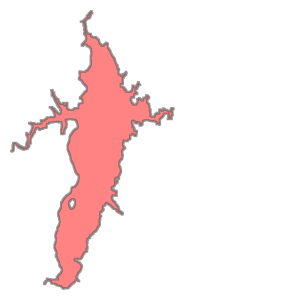

In [170]:
IDEmbalse = 3
nombre = radiosSur.loc[IDEmbalse].fna
poligono = radiosSur.loc[IDEmbalse].geometry #geometría del octavo elemento de shp
poligono

In [171]:
s2_plot_extent = plotting_extent(s2) #Bordes de la region a graficar
s2_plot_extent

# Ploteo de la imagen con los poligonos encima
bandasPosicion = [3,2,1] # RGB en este juego de bandas

# img = nequalize(s2_bandas[bandasPosicion], p=5, nodata = None)
# fig, ax = plt.subplots(figsize = (15,8))
# show(img, ax=ax, extent = s2_plot_extent, cmap = 'gray')
# if zona == 'norte':
#     radiosN.boundary.plot(ax=ax, edgecolor = 'red')
# elif zona == 'sur':
#     radiosS.boundary.plot(ax=ax, edgecolor = 'red')
# else:
#     print('Zona debe ser norte o sur')


<AxesSubplot:>

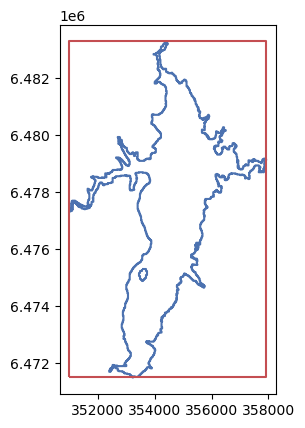

In [172]:
# RECORTO LA ZONA DE INTERES
extent = poligono.envelope

data = [poligono, extent]
gpd.GeoSeries(data).boundary.plot(color=['b', 'r'])

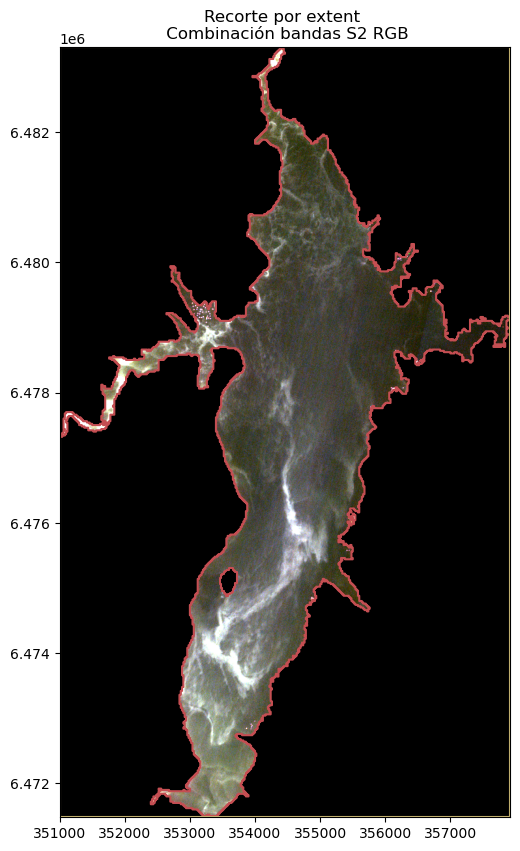

In [173]:
bandasPosicion = [3,2,1] # RGB

s2_clip, clip_transform = mask(dataset = s2, shapes = [extent], crop = True)
fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_clip[bandasPosicion],p=0.5,nodata = None), ax=ax, transform=clip_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por extent \n Combinación bandas S2 RGB")
plt.show()

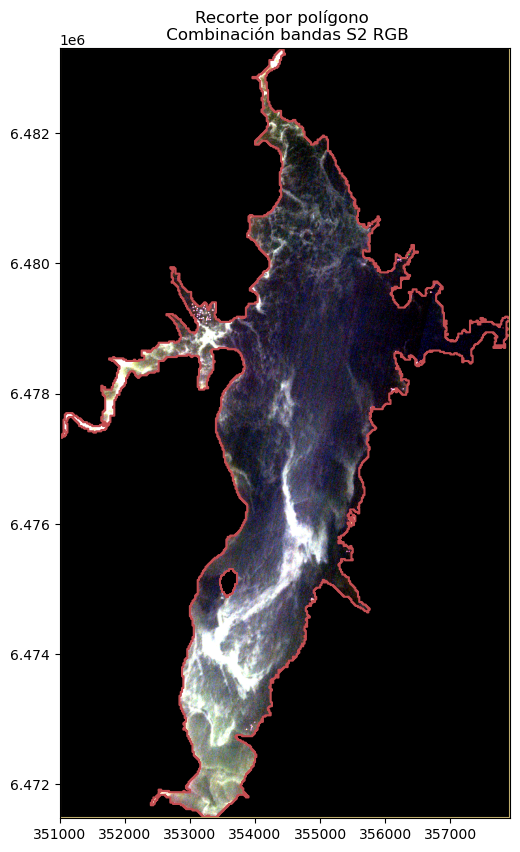

In [174]:
# Me quedo solo con lo dentro de la mascara vectorial
s2_mask, mask_transform  = mask(dataset = s2, shapes = [poligono], crop = True)

fig, ax = plt.subplots(figsize = (10,10))
show(nequalize(s2_mask[bandasPosicion], p=5), ax=ax, transform=mask_transform)
gpd.GeoSeries(data).boundary.plot(ax=ax,color=['r', 'y'])
plt.title("Recorte por polígono \n Combinación bandas S2 RGB")
plt.show()

------------------
# Clasificacion Supervisada

In [190]:
#Levanto en X, Y los datos etiquetados, como en el kmeans

#Leo los ROIS
with rasterio.open(path) as src:
    d = src.count #cantidad de atributos = cantidad de bandas en el raster
    m = src.read()

nodata = -255 #elijo un valor raro para nodata, distinto de None o np.nan (no vacio ni infinito)

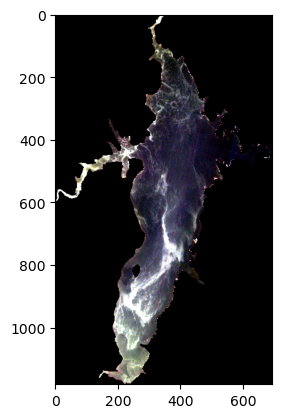

<AxesSubplot:>

In [191]:
plt.style.use('default')
show(nequalize(s2_clip[[3,2,1]], nodata = 0))

In [192]:
# El archivo shp para entrenar debe tener al menos 2 columnas, la primera de nombre CLASE con el nombre de
# cada tipo, yo use agua clara, alga densa y alga difusa. Es indistinto el nombre elegido
# La segunda columna es la geometria de cada poligono

# pols = gpd.read_file('2022/Poligonos/pol180222-2.shp')#.set_index('id') #Levanta archivo shp con los poligonos para entrenar del embalse
# pols = gpd.read_file('2022/Poligonos/polCruz-2.shp')
pols = radiosMol

#En caso de que no tenga el mismo nombre que use yo se pueden cambiar desde aca, 
# donde en el diccionario entra para cada valor del dataframe, el nuevo nombre que quiero 
# por ejemplo, de id paso a id_clase
nombres_col = {'id':'id_clase', 'clase_1':'CLASE'} 
pols.rename(columns = nombres_col, inplace = True)
pols

geometry       CLASE
0   POLYGON ((353309.984 6474162.948, 353357.895 6...  Mucha alga
1   POLYGON ((353629.392 6473907.421, 353648.024 6...  Mucha alga
2   POLYGON ((353411.130 6474253.447, 353389.836 6...  Mucha alga
3   POLYGON ((354535.714 6476062.097, 354527.729 6...  Mucha alga
4   POLYGON ((354584.956 6475939.657, 354602.257 6...  Mucha alga
5   POLYGON ((353963.440 6474701.949, 353952.793 6...   Poca alga
6   POLYGON ((354296.158 6475028.012, 354304.143 6...   Poca alga
7   POLYGON ((354296.158 6475028.012, 354304.143 6...   Poca alga
8   POLYGON ((354497.119 6475358.068, 354521.074 6...   Poca alga
9   POLYGON ((354848.468 6475616.256, 354836.490 6...   Poca alga
10  POLYGON ((353991.389 6475946.312, 354037.969 6...    Sin alga
11  POLYGON ((355380.816 6477653.816, 355411.426 6...    Sin alga
12  POLYGON ((354974.901 6478514.888, 354998.856 6...    Sin alga
13  POLYGON ((355805.363 6479220.249, 355822.664 6...    Sin alga
14  POLYGON ((353714.568 6477250.563, 353713.237 6...    Sin alga

In [193]:
pols['CLASE'].value_counts() #Cantidad de elementos por clase

Mucha alga    5
Poca alga     5
Sin alga      5
Name: CLASE, dtype: int64

In [194]:
clases=list(set(pols['CLASE']))
clases.sort() #numero las clases de los ROIs alfabéticamente
clase_dict = {clase:i for i, clase in enumerate(clases)}
clase_dict

{'Mucha alga': 0, 'Poca alga': 1, 'Sin alga': 2}

In [195]:
#Preparo colección de atributos etiquetados. Comienza con 0 datos
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas

with rasterio.open(path) as src:
    for index, row in pols.iterrows():
        poli = row['geometry']
        clase = row['CLASE']
        clip, _transform = mask(src, [poli], crop=True,nodata=None)
        d,x,y = clip.shape
        D = list(clip.reshape([d,x*y]).T)
        D = [p for p in D if (not (p==None).prod())]
        DX = np.array(D)        
        DY = np.repeat(clase_dict[clase],len(D))
        X = np.concatenate((X,DX))
        Y = np.concatenate((Y,DY))

In [196]:
L = list(Y)
E = set(L)

pixels_por_clase = {clases[y]:L.count(y) for y in E}

In [197]:
for clase in clases:
    print(f"{clase:>15s}: {pixels_por_clase[clase]}, 25%: {pixels_por_clase[clase]*0.25}") #Cantidad de pixels por clase

     Mucha alga: 2173, 25%: 543.25
      Poca alga: 836, 25%: 209.0
       Sin alga: 1643, 25%: 410.75


In [198]:
# Tomo set de entrenamiento y de testeo
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, stratify=Y, test_size = .25)#, random_state=2)  #Si quiero que sea replicable, usar el random_state

In [199]:
#Armamos y entrenamos un *Decision tree*

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
Y_pred = clf.predict(X_test)

In [200]:
# Paramentros de interes

M = confusion_matrix(y_test, Y_pred)
print('Matriz de confusión:\n',M) #Si esto me da diagonal, dudar de las cosas

acc = accuracy_score(y_test, Y_pred)
print(f'accuracy: {acc:.2f}')

k = kappa(y_test, Y_pred)
print(f'kappa index: {k:.2f}')


Matriz de confusión:
 [[542   1   0]
 [ 89 120   0]
 [143   0 268]]
accuracy: 0.80
kappa index: 0.66


In [201]:
#Armamos y entrenamos un arbol de prof 2

clf4 = DecisionTreeClassifier(max_depth = 15)
clf4 = clf4.fit(X_train, y_train)
Y_pred = clf4.predict(X_test)

acc = accuracy_score(y_test, Y_pred)
print(f'accuracy: {acc:.2f}')

k = kappa(y_test, Y_pred)
print(f'kappa index: {k:.2f}')

accuracy: 0.80
kappa index: 0.66


In [202]:
# bandas = ['Banda 1', 'Azul', 'Verde', 'Rojo', 'Banda 5', 'Banda 6', 'Banda 7', 'NIR', 'Banda 9', 'SWIR 1', 'SWIR 2']
bandas = ['Banda 1', 'Azul', 'Verde', 'Rojo', 'Banda 5', 'Banda 6', 'Banda 7', 'NIR', 'SWIR1', 'SWIR2']

feature_names = bandas

n_nodes = clf4.tree_.node_count
children_left = clf4.tree_.children_left
children_right = clf4.tree_.children_right
feature = clf4.tree_.feature
threshold = clf4.tree_.threshold
hojas = [clases[np.argmax(clf4.tree_.value[i][0])] for i in range(n_nodes)]

n_nodes

9

In [203]:
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # comienza con el nodo raiz (0) con profundidad (0)
while len(stack) > 0:

    node_id, depth = stack.pop() #Me aseguro que cada nodo sea recorrido solo una vez
    node_depth[node_id] = depth

    # Si a izq y der no son el mismo nodo, entonces split
    # nodo
    is_split_node = children_left[node_id] != children_right[node_id]

    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print("El árbol binario tiene una estructura con {n} nodos:\n".format(n=n_nodes))
for i in range(n_nodes):
    if is_leaves[i]:
        print("{space}N{node}: HOJA {clase}.".format(
            space=node_depth[i] * "\t", node=i, clase = hojas[i]))
    else:
        print("{space}N{node}: SI ({feature} <= {threshold:.3f}) -> N{left}, SINO -> N{right}.".format(
                  space=node_depth[i] * "\t",
                  node=i,
                  left=children_left[i],
                  feature=feature_names[feature[i]],
                  threshold=threshold[i],
                  right=children_right[i]))

El árbol binario tiene una estructura con 9 nodos:

N0: SI (NIR <= 442.000) -> N1, SINO -> N6.
	N1: SI (Banda 1 <= 30.000) -> N2, SINO -> N3.
		N2: HOJA Mucha alga.
		N3: SI (Rojo <= 107.000) -> N4, SINO -> N5.
			N4: HOJA Sin alga.
			N5: HOJA Poca alga.
	N6: SI (Verde <= 429.000) -> N7, SINO -> N8.
		N7: HOJA Poca alga.
		N8: HOJA Mucha alga.


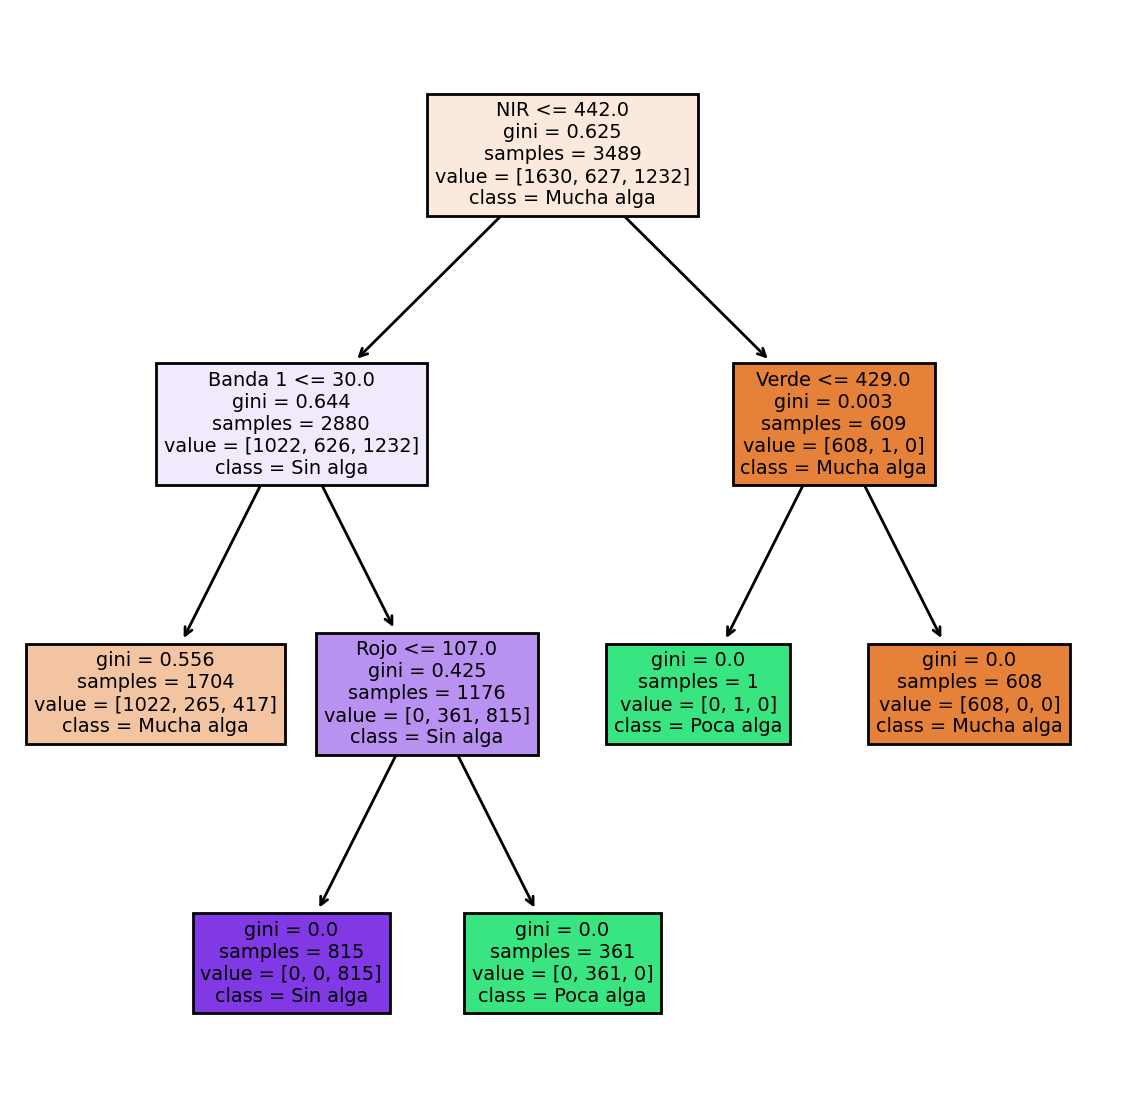

In [204]:
# Ploteo arbol de decision
fig = plt.figure(figsize = (7,7), dpi = 200)
_ = tree.plot_tree(clf4, 
                   feature_names = bandas,  
                   class_names = clases,
                   filled = True)

In [205]:
# Testeo!
# armamos una lista de maximas profundidades y vemos cual ajusta mejor
lmd = np.arange(2,11)
scoresTest = []
scoresTrain = []

for md in lmd:
    clf = tree.DecisionTreeClassifier(max_depth = md)
    clf = clf.fit(X_train, y_train)
    Y_pred = clf.predict(X_test)
    acc_test = accuracy_score(y_test, Y_pred)
    scoresTest.append(acc_test)
    acc_train = accuracy_score(y_train, clf.predict(X_train))
    scoresTrain.append(acc_train)
    print(f'Prof {md:>2d}: Train {acc_train:.3f}, Test: {acc_test:.3f}')

# Se me estancó en 2, no estoy seguro porque, despues lo chequeo.

Prof  2: Train 0.701, Test: 0.697
Prof  3: Train 0.805, Test: 0.800
Prof  4: Train 0.805, Test: 0.800
Prof  5: Train 0.805, Test: 0.800
Prof  6: Train 0.805, Test: 0.800
Prof  7: Train 0.805, Test: 0.800
Prof  8: Train 0.805, Test: 0.800
Prof  9: Train 0.805, Test: 0.800
Prof 10: Train 0.805, Test: 0.800


In [206]:
#busco el mejor score en el train set
imx = np.argmax(scoresTest)
best_prof = lmd[imx]
acc = scoresTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para un árbol\nde profundidad {best_prof} con una exactitud de {acc:.3f}')

El mejor resultado en el conjunto de testeo fue obtenido para un árbol
de profundidad 3 con una exactitud de 0.800


In [106]:
from sklearn.model_selection import StratifiedKFold

n_splits = 10
lmd = np.arange(2,25)
accTest = np.zeros([len(lmd),n_splits])
accTrain = np.zeros([len(lmd),n_splits])

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
for j, (train_index, test_index) in enumerate(skf.split(X, Y)):
    print(f'fold {j+1} de {n_splits}.')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    for i,md in enumerate(lmd):
        clf = tree.DecisionTreeClassifier(max_depth = md)
        clf = clf.fit(X_train, y_train)
        accTest[i,j] = accuracy_score(y_test, clf.predict(X_test))
        accTrain[i,j] = accuracy_score(y_train, clf.predict(X_train))

fold 1 de 10.
fold 2 de 10.
fold 3 de 10.
fold 4 de 10.
fold 5 de 10.
fold 6 de 10.
fold 7 de 10.
fold 8 de 10.
fold 9 de 10.
fold 10 de 10.


In [107]:
print(f'\n\nExactitud para cada max_depth (filas) y las {n_splits} corridas:\n')
print('*',' '.join([f'Corrida {i+1} ' for i in range(n_splits)]),'*')
print(accTest)



Exactitud para cada max_depth (filas) y las 10 corridas:

* Corrida 1  Corrida 2  Corrida 3  Corrida 4  Corrida 5  Corrida 6  Corrida 7  Corrida 8  Corrida 9  Corrida 10  *
[[0.65269944 0.6357776  0.67284448 0.66156326 0.64786463 0.66881547
  0.65753425 0.65269944 0.65592264 0.65753425]
 [0.76067687 0.74939565 0.75503626 0.7743755  0.77518131 0.75664786
  0.76148268 0.76228848 0.74778405 0.76712329]
 [0.76309428 0.75181305 0.75906527 0.77921031 0.77921031 0.75987107
  0.76551168 0.76390008 0.75906527 0.7719581 ]
 [0.7719581  0.75987107 0.76148268 0.78646253 0.78485093 0.76631749
  0.77034649 0.76712329 0.76470588 0.77840451]
 [0.7719581  0.76148268 0.76309428 0.78726833 0.78565673 0.76470588
  0.7711523  0.76873489 0.76470588 0.77921031]
 [0.7719581  0.76148268 0.76390008 0.78646253 0.78565673 0.76551168
  0.7711523  0.76792909 0.76551168 0.77840451]
 [0.7735697  0.76067687 0.76309428 0.78646253 0.78485093 0.76551168
  0.7711523  0.76792909 0.76551168 0.77921031]
 [0.7727639  0.76148

In [108]:
#Calculo promedios de los K folds
scoresTest = accTest.mean(axis=1)
scoresTrain = accTrain.mean(axis=1)

#Busco el mejor resultado
imx = np.argmax(scoresTest)
best_prof = lmd[imx]
best_acc = scoresTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para un arbol de profundidad {best_prof} y una exactitud de {best_acc:.3f}')

El mejor resultado en el conjunto de testeo fue obtenido para un arbol de profundidad 16 y una exactitud de 0.772


In [109]:
# Uso el mejor de todos
clf12 = tree.DecisionTreeClassifier(max_depth = best_prof)
clf12 = clf12.fit(X, Y)

#Leo la imágen completa
raster_fn = path
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform

d,x,y = s2_clip.shape

# uso el modelo para clasificar la imagen del embalse
Y_pred = clf12.predict(s2_clip.reshape([d,x*y]).T)


In [110]:
#Elimino los bordes que no me importa que lo clasifique

contorno = Y_pred.reshape([x,y])
contorno = contorno.astype('float64')
contorno[np.where(s2_mask[0] == 0)] = np.nan

In [111]:
from matplotlib.patches import Patch


In [120]:
clases

['Agua Clara', 'Agua Sedimentos', 'Alga Difusa']

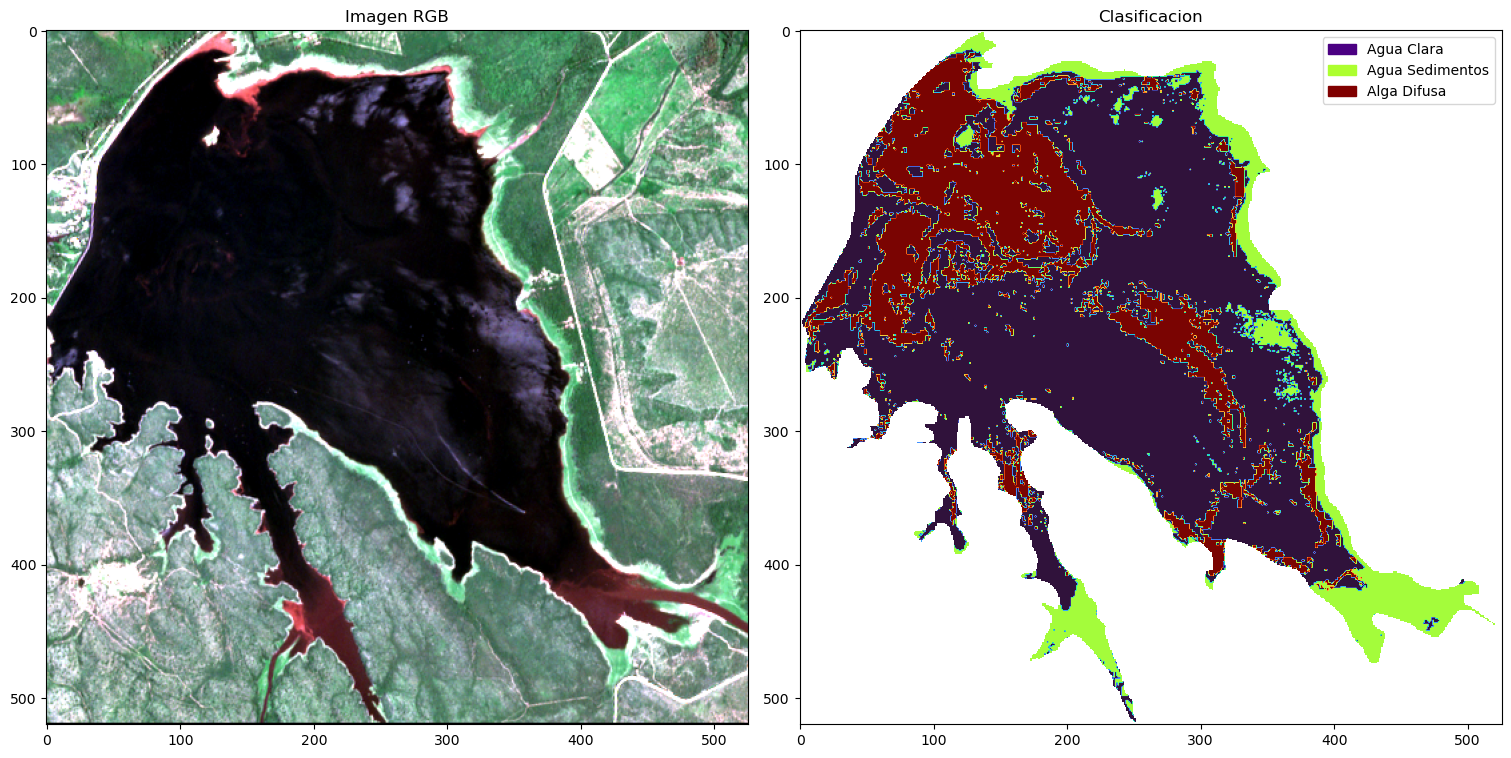

In [122]:
rgb = np.einsum('kij->ijk',nequalize(s2_clip[[3,2,1]], p=5))

# fig, ax = plt.subplots(1,3, figsize = (15,10), constrained_layout=True)
fig, ax = plt.subplots(1,2, figsize = (15,10), constrained_layout=True)
ax[0].imshow(rgb)
# ax[1].imshow(Y_pred.reshape([x,y]),cmap='gnuplot2')
# ax[2].imshow(contorno,cmap='gnuplot2')
ax[1].imshow(contorno, cmap='turbo')

patch_aguaClara = Patch(color='indigo', label=clases[0])
patch_aguaTurbia = Patch(color='greenyellow', label=clases[1])
patch_algaDif = Patch(color='maroon', label=clases[2])

ax[1].legend(handles=[patch_aguaClara,patch_aguaTurbia,patch_algaDif])

ax[0].title.set_text('Imagen RGB')
ax[1].title.set_text('Clasificacion')
# ax[2].title.set_text('Embalse')
# fig.suptitle('Desicion Tree', fontsize=20)

-----------
# Random Forest

In [175]:
#Levanto en X, Y los datos etiquetados, como en el kmeans

#Leo los ROIS
with rasterio.open(path) as src:
    d = src.count #cantidad de atributos = cantidad de bandas en el raster
    m = src.read()

nodata = -255 #elijo un valor raro para nodata, distinto de None o np.nan (no vacio ni infinito)

In [176]:
# El archivo shp para entrenar debe tener al menos 2 columnas, la primera de nombre CLASE con el nombre de
# cada tipo, yo use agua clara, alga densa y alga difusa. Es indistinto el nombre elegido
# La segunda columna es la geometria de cada poligono

# pols = gpd.read_file('2022/Poligonos/pol180222-2.shp')#.set_index('id') #Levanta archivo shp con los poligonos para entrenar del embalse
# pols = gpd.read_file('2022/Poligonos/polCruz-2.shp')
pols = radiosMol

#En caso de que no tenga el mismo nombre que use yo se pueden cambiar desde aca, 
# donde en el diccionario entra para cada valor del dataframe, el nuevo nombre que quiero 
# por ejemplo, de id paso a id_clase
nombres_col = {'id':'id_clase', 'clase_1':'CLASE'} 
pols.rename(columns = nombres_col, inplace = True)

clases=list(set(pols['CLASE']))
clases.sort() #numero las clases de los ROIs alfabéticamente
clase_dict = {clase:i for i, clase in enumerate(clases)}
clase_dict, pols['CLASE'].value_counts()

({'Mucha alga': 0, 'Poca alga': 1, 'Sin alga': 2},
 Mucha alga    5
 Poca alga     5
 Sin alga      5
 Name: CLASE, dtype: int64)

In [177]:
#Preparo colección de atributos etiquetados. Comienza con 0 datos
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas

with rasterio.open(path) as src:
    for index, row in pols.iterrows():
        poli = row['geometry']
        clase = row['CLASE']
        clip, _transform = mask(src, [poli], crop=True,nodata=None)
        d,x,y = clip.shape
        D = list(clip.reshape([d,x*y]).T)
        D = [p for p in D if (not (p==None).prod())]
        DX = np.array(D)        
        DY = np.repeat(clase_dict[clase],len(D))
        X = np.concatenate((X,DX))
        Y = np.concatenate((Y,DY))

In [178]:
L = list(Y)
E = set(L)

pixels_por_clase = {clases[y]:L.count(y) for y in E}

In [179]:
for clase in clases:
    print(f"{clase:>15s}: {pixels_por_clase[clase]}, 25%: {pixels_por_clase[clase]*0.25}") #Cantidad de pixels por clase

     Mucha alga: 2173, 25%: 543.25
      Poca alga: 836, 25%: 209.0
       Sin alga: 1643, 25%: 410.75


In [180]:
#separo en train y test
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X, Y, test_size = .25)

#entreno un modelo
clf = RandomForestClassifier(n_estimators = 100, max_depth = 12)
clf.fit(X_train_rf, Y_train_rf)

#lo evaluo
Y_pred_rf = clf.predict(X_test_rf)
print("Accuracy:", metrics.accuracy_score(Y_test_rf, Y_pred_rf))

Accuracy: 0.7953568357695615


In [181]:
# Paramentros de interes
M = confusion_matrix(Y_test_rf, Y_pred_rf)
print('Matriz de confusión:\n',M) #Si esto me da diagonal, dudar de las cosas

acc = accuracy_score(Y_test_rf, Y_pred_rf)
print(f'accuracy: {acc:.2f}')

k = kappa(Y_test_rf, Y_pred_rf)
print(f'kappa index: {k:.2f}')

Matriz de confusión:
 [[523   0   0]
 [101 121   0]
 [137   0 281]]
accuracy: 0.80
kappa index: 0.66


In [182]:
n_splits = 10
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
print(skf)

valores_prof = [2,3,4,5,10,15,20,30]
valores_estim = [10,25,50]#100,120,150,180,200]

resultados_test = np.zeros((n_splits, len(valores_prof), len(valores_estim)))
resultados_train = np.zeros((n_splits, len(valores_prof), len(valores_estim)))

split = 0
for train_index, test_index in skf.split(X,Y):
    print(f"Fold {split + 1}:")
    for i,d in enumerate(valores_prof):
        print(f" - arboles de profundidad {d}")
        for j,n in enumerate(valores_estim):
            X_train_rf, X_test_rf = X[train_index,:], X[test_index,:]
            Y_train_rf, Y_test_rf = Y[train_index], Y[test_index]
            model = RandomForestClassifier(n_estimators = n, max_depth = d)
            model.fit(X_train_rf, Y_train_rf) 
            Y_pred_rf = model.predict(X_test_rf)
            Y_pred_train_rf = model.predict(X_train_rf)
            acc_test = metrics.accuracy_score(Y_test_rf, Y_pred_rf)
            acc_train = metrics.accuracy_score(Y_train_rf, Y_pred_train_rf)
            resultados_test[split, i, j] = acc_test
            resultados_train[split, i, j] = acc_train
            
            # M = confusion_matrix(X_test_rf, Y_pred_train_rf)
            # print('Matriz de confusión:\n',M) #Si esto me da diagonal, dudar de las cosas
            # print("Accuracy:", metricsaccuracy_score(X_test_rf, Y_pred_train_r))
            # k = kappa(X_test_rf, Y_pred_train_rf)
            # print(f'kappa index: {k:.2f}')
            
    split += 1

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
Fold 1:
 - arboles de profundidad 2
 - arboles de profundidad 3
 - arboles de profundidad 4
 - arboles de profundidad 5
 - arboles de profundidad 10
 - arboles de profundidad 15
 - arboles de profundidad 20
 - arboles de profundidad 30
Fold 2:
 - arboles de profundidad 2
 - arboles de profundidad 3
 - arboles de profundidad 4
 - arboles de profundidad 5
 - arboles de profundidad 10
 - arboles de profundidad 15
 - arboles de profundidad 20
 - arboles de profundidad 30
Fold 3:
 - arboles de profundidad 2
 - arboles de profundidad 3
 - arboles de profundidad 4
 - arboles de profundidad 5
 - arboles de profundidad 10
 - arboles de profundidad 15
 - arboles de profundidad 20
 - arboles de profundidad 30
Fold 4:
 - arboles de profundidad 2
 - arboles de profundidad 3
 - arboles de profundidad 4
 - arboles de profundidad 5
 - arboles de profundidad 10
 - arboles de profundidad 15
 - arboles de profundidad 20
 - arboles de profundid

In [183]:
promedios_test = np.mean(resultados_test, axis = 0) 

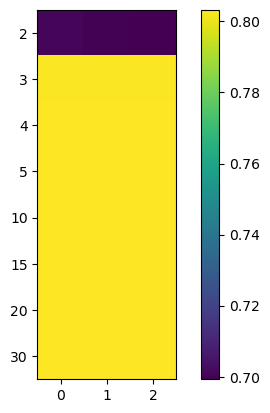

In [184]:
fig, ax = plt.subplots()
axx = ax.imshow(promedios_test)

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(valores_prof)), labels=[str(v) for v in valores_prof])
ax.set_xticks(np.arange(len(valores_estim)))#, labels=valores_estim)
fig.colorbar(axx)

In [185]:
ind = np.unravel_index(np.argmax(promedios_test, axis=None), promedios_test.shape)
opt_d = valores_prof[ind[0]]
opt_n = valores_estim[ind[1]]
max_acc = promedios_test[ind]

print(f"El mejor promedio fue obtenido para profundidad {opt_d} y {opt_n} arboles, con una exactitud de {max_acc:.3f}")

El mejor promedio fue obtenido para profundidad 4 y 50 arboles, con una exactitud de 0.803


In [186]:
#entreno un modelo
X_train_rf, X_test_rf, Y_train_rf, Y_test_rf = train_test_split(X, Y, test_size = .25)
clf = RandomForestClassifier(n_estimators = opt_d, max_depth = opt_n)
clf.fit(X_train_rf, Y_train_rf)

#Leo la imágen completa
raster_fn = path
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform

d,x,y = s2_clip.shape

# uso el modelo para clasificar la imagen del embalse
# Y_pred_rf = clf.predict(X_test_rf)/
Y_pred_rf = clf.predict(s2_clip.reshape([d,x*y]).T)

In [187]:
# Paramentros de interes
Y_pred_test = clf.predict(X_test_rf)

M = confusion_matrix(Y_test_rf, Y_pred_test)


print('Matriz de confusión:\n',M) #Si esto me da diagonal, dudar de las cosas

print("Accuracy:",accuracy_score(Y_test_rf, Y_pred_test))

k = kappa(Y_test_rf, Y_pred_test)
print(f'kappa index: {k:.2f}')

Matriz de confusión:
 [[529   0   0]
 [ 92 135   0]
 [141   0 266]]
Accuracy: 0.7996560619088564
kappa index: 0.67


In [188]:
#Elimino los bordes que no me importa que lo clasifique

contorno_rf = Y_pred_rf.reshape([x,y])
contorno_rf = contorno_rf.astype('float64')
contorno_rf[np.where(s2_mask[0] == 0)] = np.nan

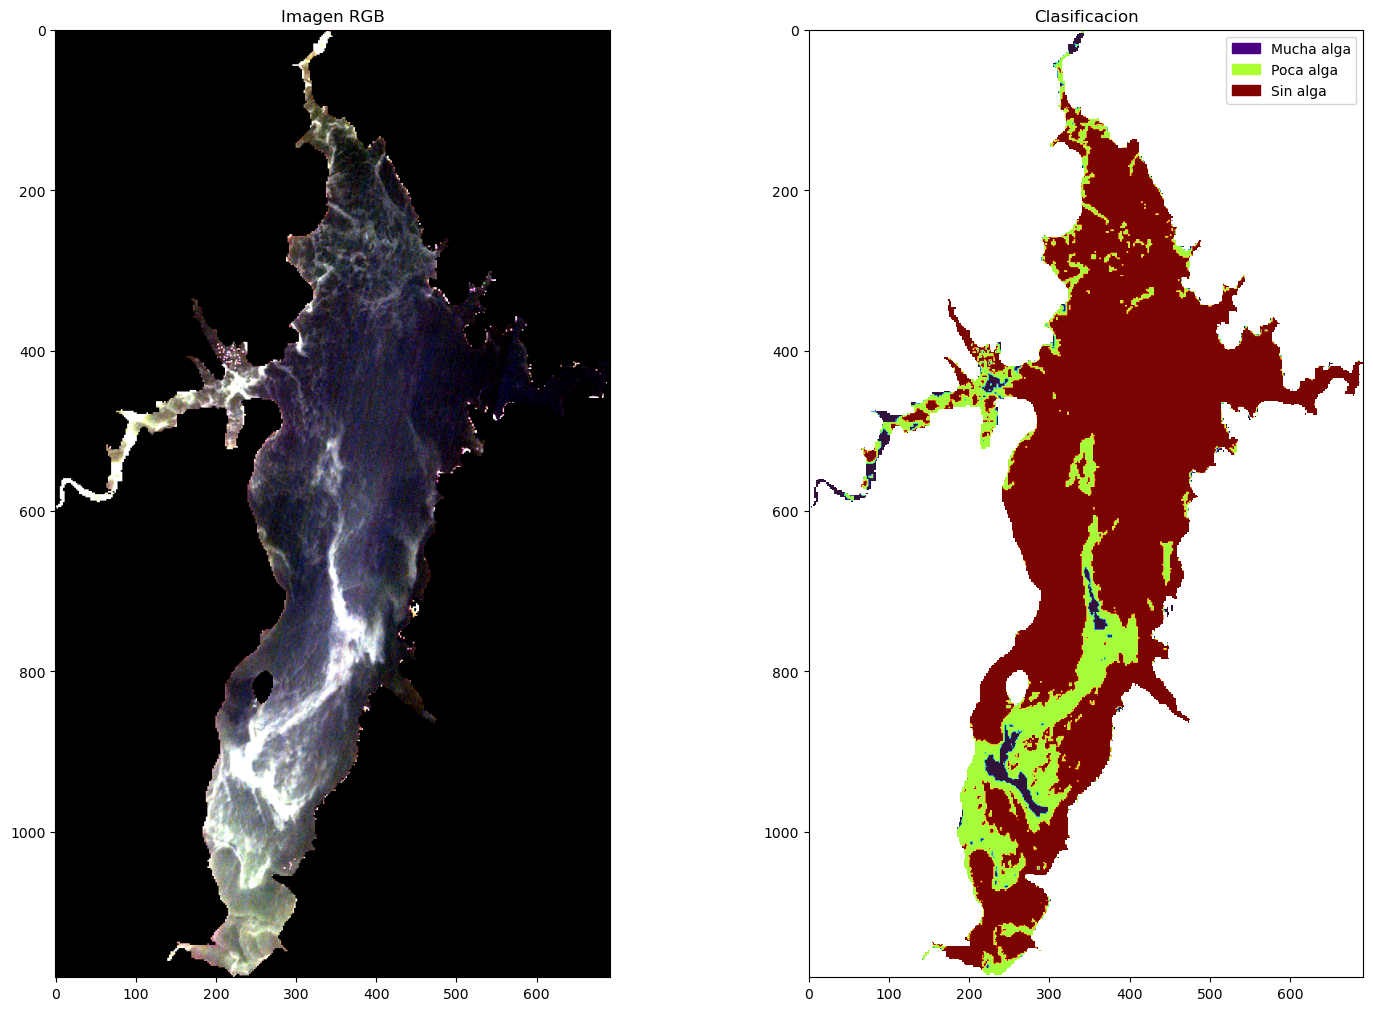

In [189]:
rgb = np.einsum('kij->ijk',nequalize(s2_clip[[3,2,1]]))

plt.style.use('default')

# fig, ax = plt.subplots(1,3, figsize = (15,10), constrained_layout=True)
fig, ax = plt.subplots(1,2, figsize = (15,10), constrained_layout=True)
ax[0].imshow(rgb)
# ax[1].imshow(Y_pred_rf.reshape([x,y]),cmap='gnuplot2')
# ax[2].imshow(contorno_rf,cmap='gnuplot2')

# colors = ['blue',
#           'yellow',
#           'darkgreen',
#           'maroon']
# cmap = matplotlib.colors.ListedColormap(colors)
ax[1].imshow(contorno_rf,cmap='turbo')

patch_aguaClara = Patch(color='indigo', label=clases[0])
patch_aguaTurbia = Patch(color='greenyellow', label=clases[1])
patch_algaDif = Patch(color='maroon', label=clases[2])
ax[1].legend(handles=[patch_aguaClara,patch_aguaTurbia,patch_algaDif])

ax[0].title.set_text('Imagen RGB')
ax[1].title.set_text('Clasificacion')
# ax[2].title.set_text('Embalse')
# fig.suptitle('Random Forest', fontsize=20)

In [162]:
labelss = []
for a in clase_dict.keys():
    labelss.append(a) 
    
df_cm = pd.DataFrame(M, index = labelss, columns = labelss)
df_cm

Agua Clara  Alga Densa  Alga Difusa
Agua Clara          964           0            0
Alga Densa          143         150            0
Alga Difusa         314           0          220

<AxesSubplot:>

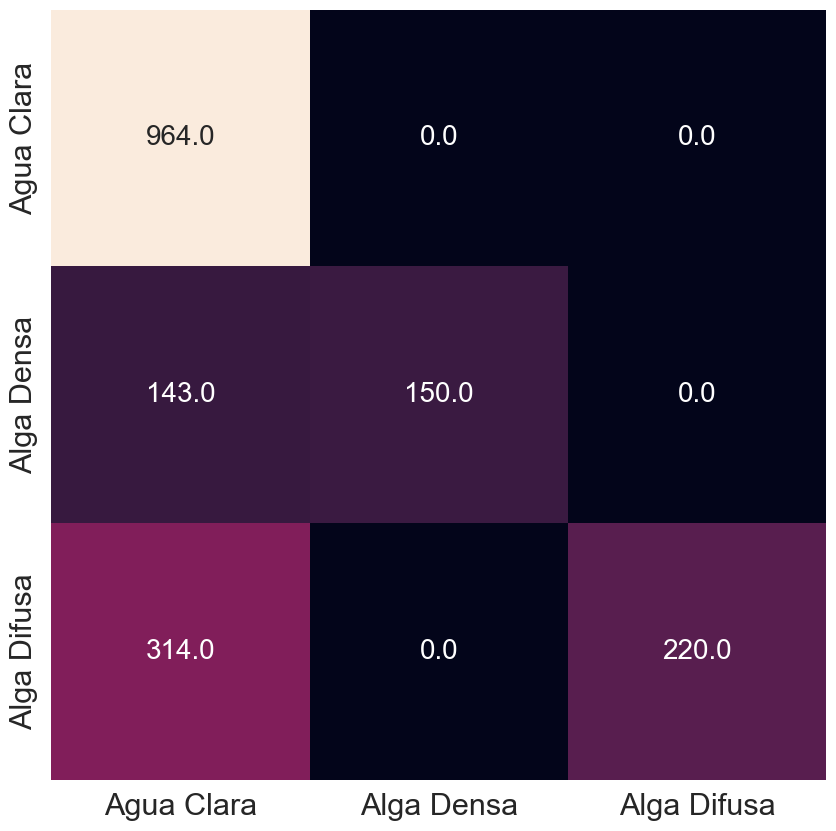

In [163]:
plt.figure(figsize = (10,10))
sns.set(font_scale=2)
sns.heatmap(df_cm,annot=True, cbar=False, annot_kws={"size": 20}, fmt=".1f")